## How to generate pulsar frequencies :: residuals method




This notebook explores how to take some pulsar data (`.tim` and `.par` files) from the [IPTA Mock Data Challenge](https://web.archive.org/web/20130108011819/http://www.ipta4gw.org/?page_id=126) (see also [https://github.com/nanograv/mdc1](https://github.com/nanograv/mdc1)) and generate some frequencies $f$ for use with state-space methods like Kalman filtering.

It is a pedagogical guide, heavily based off of [guidance from L. Dunn](https://gist.github.com/ldunn/0ee22b40397965f4644ea8d1bc2f1a77).

The methods presented in this notebook are a little different to Liam's original notes. The original method has some small complications regarding the barycentering corrections which this method circumvents. The old method notebook can be found in `legacy/01.explore_how_to_generate_frequencies`


## 1. Imports and setup

We use the [libstempo](https://github.com/vallis/libstempo) python wrapper for `tempo2`. Specifically we use L.Dunn's branch, see [Liam's installation notes](https://gist.github.com/ldunn/04a20627941df1a7f96f6fd5a0a291b9).

When importing `tempo2` we have to set the `TEMPO2` environment variable. We don't have to do this when working directly in the shell, but inside a Jupyter notebook [it seems necessary (?!)](https://github.com/microsoft/vscode/issues/163612)


In [115]:
import os 
os.environ['TEMPO2'] = '/fred/oz022/tkimpson/tempo2/T2runtime' # set the environment variable
import libstempo

## 2. Generating TOAs

Again, lets look at how to generate some TOAs using our data files + `libstempo`


In [116]:
# First define the data to use
import glob
path_to_data = '../mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/'
list_of_par_files = sorted(glob.glob(path_to_data+'/*.par'))
list_of_tim_files = sorted(glob.glob(path_to_data+'/*_pn.tim')) # we operate on tim files that have been modified to include pulse numbering 
assert len(list_of_par_files) == len(list_of_tim_files)

In [117]:
#Pick a particular pulsar
psr_idx = 0
par_file = list_of_par_files[psr_idx]
tim_file = list_of_tim_files[psr_idx]

/tmp/ipykernel_866715/3774928690.py:2: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)


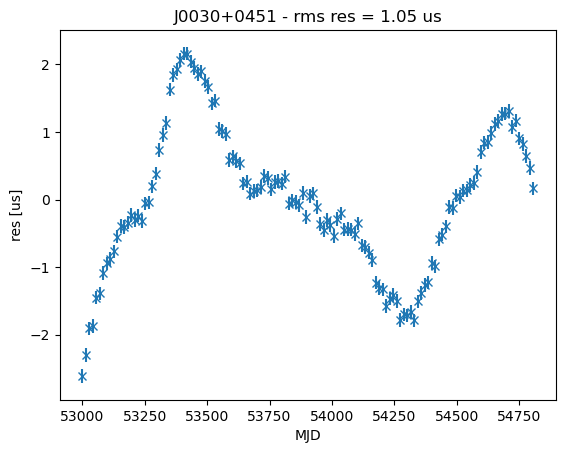

In [118]:
#Generate a tempopulsar object 
psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)
psr['TRACK'].val = -2
import libstempo.plot
#Plot it 
libstempo.plot.plotres(psr)

Now lets correct the TOAs given our timing model 

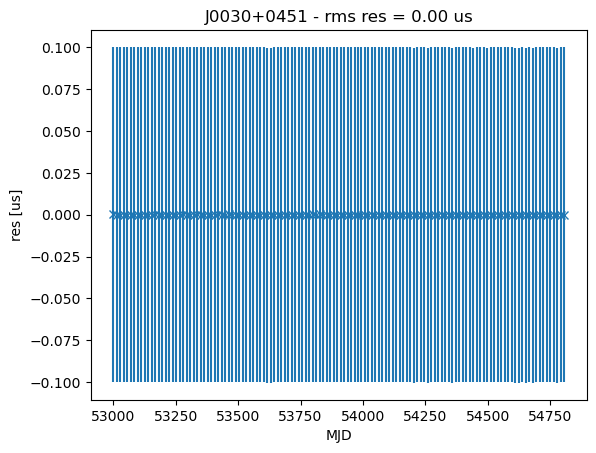

In [119]:
import libstempo.toasim as toasim
toasim.make_ideal(psr) # make_ideal shifts the ToAs so that they are exactly aligned with the timing model we loaded
toasim.make_ideal(psr) # For whatever reason doing two passes of make_ideal gets a better result - with just one you can end up with a slight trend in the residuals
libstempo.plot.plotres(psr)


i.e. zero residuals with some error bars. This makes sense because the TOAs were generated via the timing model and so agree exactly.


## 3. Adding noise 


Now lets add some noise to these TOAs. We are interested in 3 different types:

* White noise (i.e. measurement noise)
* Red noise (uncorrelated between PSRs) i.e. intrinstic pulsar spin noise 
* Red noise (correlated between PSRs) i.e. the stochastic GW background 

We use libstempo to add thees noises. See https://github.com/vallis/libstempo/blob/master/libstempo/toasim.py

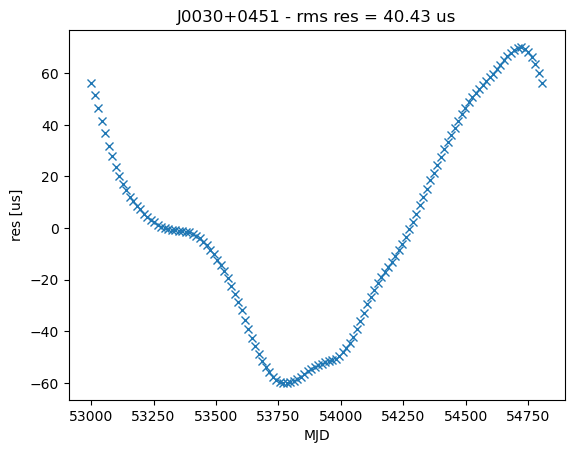

In [120]:
#Parameters

## Random seeding
noise_seed = 1

## GW parameters
alpha=-2/3 # this is defined as being negative
gw_amplitude = 5e-14

## Red noise parameters
gamma = 4 #...this is positive
A = 1e-12


## White noise parameters
efac = 1.0 # Scales the errors defined in the .tim file 

## Now add noise 
toasim.add_rednoise(psr,A, gamma,seed=noise_seed)                     # Add some red noise 
toasim.add_efac(psr,seed=noise_seed,efac=efac)                        # Add white noise at the level specified in the .tim file
toasim.add_gwb(psr,seed=noise_seed, gwAmp=gw_amplitude, alpha=alpha)  # Add GW backgriund given an amplitude and an index

libstempo.plot.plotres(psr)






## 4. Generating frequencies


Given these TOAs that are perturbed by different noise processes, we want to obtain a frequency timeseries $f(t)$ to be ingested by the Kalman filter.

Here we generate $f^{*} = f - f_{\rm TM}$, i.e. a frequency timeseries with the secular trend subtracted off (we can add this in later)


Previously we used $$f(t) = \frac{\Delta \phi}{\Delta t}=\frac{\phi(t_{i+1}) - \phi({t_i})}{t_{i+1} - t_{i}}$$


We can do something similar here as follows

$$\text{residual}(t) = \phi(t) - \phi_{\rm TM}(t)$$


where $\phi_{\rm TM}(t)$ is the phase evolution given the timing model 

$$f^*(t) = \frac{\text{residual}(t_{i+1})-\text{residual}(t_{i})}{t_{i+1} - t_{i}}$$

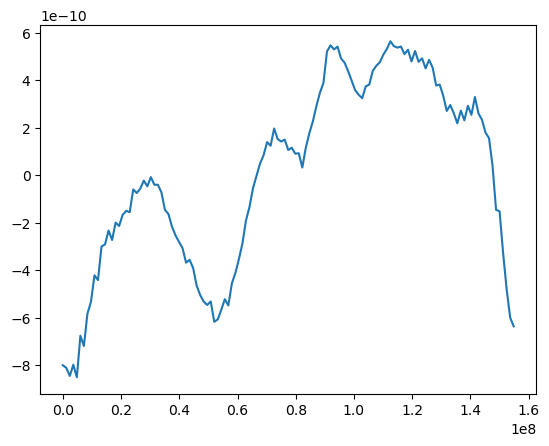

In [121]:
import matplotlib.pyplot as plt 
import numpy as np 

residuals  = psr.residuals()       # units of seconds
pulsar_emission_times = (psr.pets()-psr.pets()[0])*86400 # PET for Pulsar Emission Time - these are the ToAs in the pulsar frame. PETs are in MJD so multiply by 86400 to get seconds


dt = np.diff(pulsar_emission_times)
dres = np.diff(residuals)

f = dres/dt 
f_Hz = f*psr['F0'].val # F0 factor for units 

#Consider the frequencies to be evaluated at the lower end of the box - arbitrary
t_eval = pulsar_emission_times[0:-1]

plt.plot(t_eval,f_Hz)


We can also add back in the secular trend:

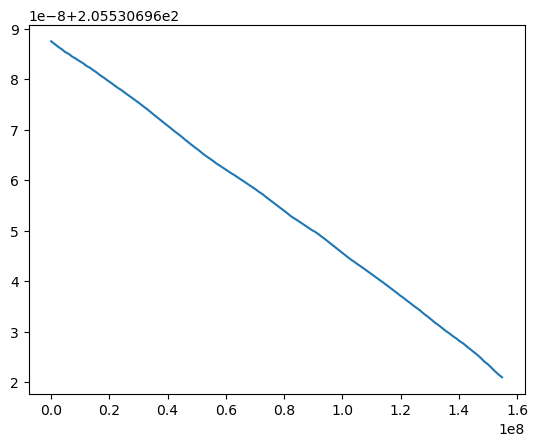

In [122]:
f_secular = psr['F0'].val + psr['F1'].val*t_eval + f_Hz
plt.plot(t_eval, f_secular)

# Zero noise example 


To finish, lets see what the frequency timeseries looks like when we have no (red,white,GW) noise 

In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import sys 
sys.path.append("../scripts")
from generate_frequency_timeseries import process_pulsar_files

Processing pulsar J0030+0451


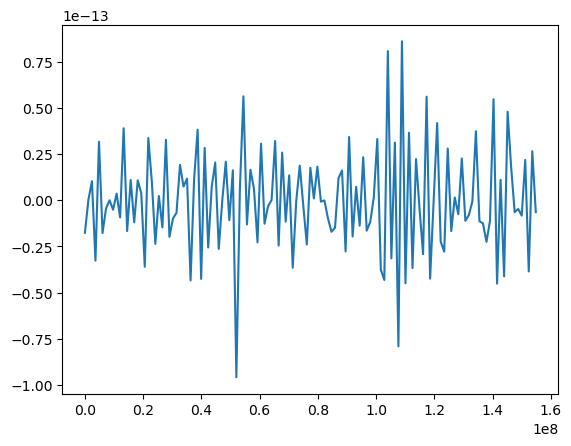

In [127]:
#par_file and tim_file defined above
noise_seed = 1 
gwb = toasim.GWB(ngw=int(1e3),
                 seed=noise_seed,
                 gwAmp=0.0,
                 alpha=-2/3)
psr_alpha = 4 
psr_amplitude = 0
efac = 0
t,f, F0,F1,DECJ,RAJ,_,_ = process_pulsar_files(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac)

plt.plot(t,f)


...and again we can add back on the secular trend

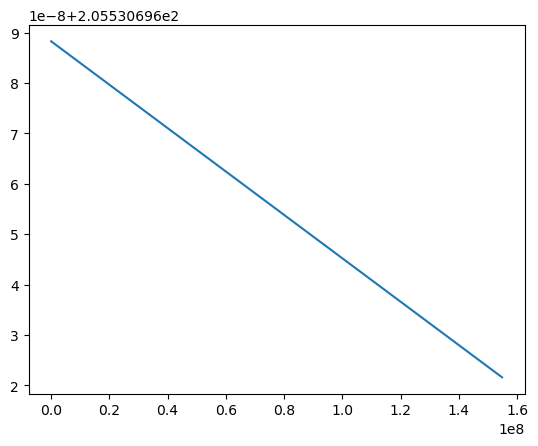

In [128]:
f_secular = F0 + F1*t + f
plt.plot(t_eval, f_secular)

# Just GWB


Lets see what the frequency timeseries looks like when we have no PSR red noise, just a GWB

Processing pulsar J0030+0451


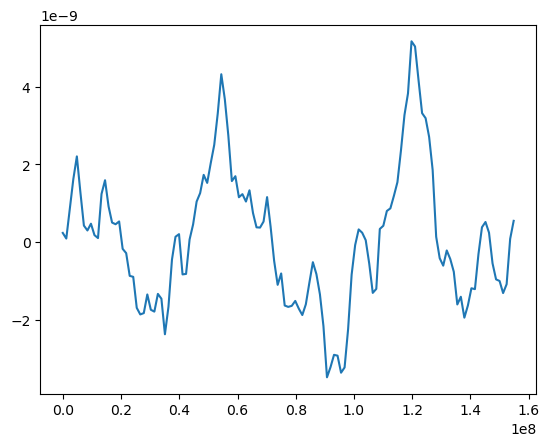

In [130]:
#par_file and tim_file defined above
noise_seed = 1 
gwb = toasim.GWB(ngw=int(1e3),
                 seed=noise_seed,
                 gwAmp=1e-11,
                 alpha=-2/3)
psr_alpha = 4 
psr_amplitude = 0
efac = 1
t,f, F0,F1,DECJ,RAJ,_,_ = process_pulsar_files(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac)

plt.plot(t,f)


# Dataset 3 example 

Lets include the red noise as it is given in dataset 3 in the [MDC](https://web.archive.org/web/20130108011819/http://www.ipta4gw.org/?page_id=126)

Processing pulsar J0030+0451


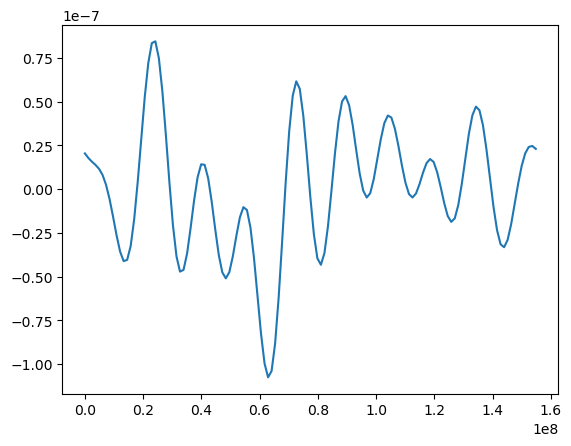

In [131]:
#par_file and tim_file defined above
noise_seed = 10 
gwb = toasim.GWB(ngw=int(1e3),
                 seed=noise_seed,
                 gwAmp=1e-14,
                 alpha=-2/3)
psr_alpha = 1.7 
psr_amplitude = np.sqrt(5.77e-22*12*np.pi**2) # from how the amplitude is defined in libstepo. https://github.com/vallis/libstempo/blob/master/libstempo/toasim.py#L298
efac = 1.0
t,f, F0,F1,DECJ,RAJ,residuals,pets = process_pulsar_files(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac)

plt.plot(t,f)


Text(0, 0.5, 'res')

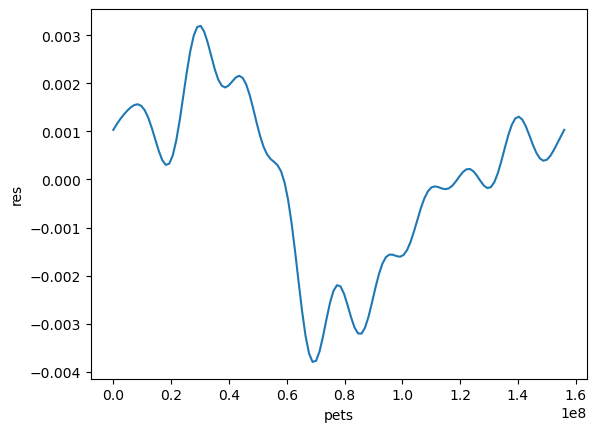

In [132]:
plt.plot(pets, residuals)
plt.xlabel('pets')
plt.ylabel('res')

# Appendix 

Processing pulsar J0030+0451


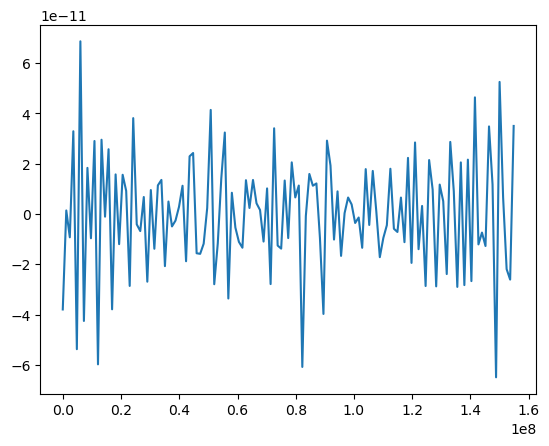

In [135]:
#par_file and tim_file defined above
noise_seed = 1 
gwb = toasim.GWB(ngw=int(1e3),
                 seed=noise_seed,
                 gwAmp=1e-20,
                 alpha=-2/3)
psr_alpha = 4 
psr_amplitude = 0
efac = 1
t,f, F0,F1,DECJ,RAJ,_,_ = process_pulsar_files(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac)

plt.plot(t,f)


In [136]:
f20 = f 

In [140]:
#par_file and tim_file defined above
noise_seed = 1 
gwb = toasim.GWB(ngw=int(1e3),
                 seed=noise_seed,
                 gwAmp=0.0,
                 alpha=-2/3)
psr_alpha = 4 
psr_amplitude = 0
efac = 0.0
t,f, F0,F1,DECJ,RAJ,_,_ = process_pulsar_files(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac)

#plt.plot(t,f)
plt.plot(t,-f20)

Processing pulsar J0030+0451


ValueError: too many values to unpack (expected 8)